In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from google.colab import drive
from google.colab import files
import os
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import numpy as np
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import zipfile
import pandas as pd

# Путь к архиву
base_path = '/content/drive/MyDrive/ГО 2025/NLP соревнование 2'
zip_path = os.path.join(base_path, 'dl-2025-study-competition-2.zip')

# Распаковываем архив
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')  # распаковываем в корень Colab

# Теперь читаем файлы
train = pd.read_csv('/content/train.csv', index_col='id')
test = pd.read_csv('/content/test.csv', index_col='id')

# Проверяем, что данные загружены
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Mounted at /content/drive
Train shape: (29568, 2)
Test shape: (7392, 1)


In [ ]:
# test

## 1) Проанализировать данные, посмотреть на баланс классов, посмотреть на представителей классов, поизучать текста, сделать выводы. (0.5 балла).

In [ ]:
train.head(3)

,text,labels
id,,
0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1


In [ ]:
# Разбиваем строку с метками на отдельные числа
train['labels'] = train['labels'].apply(lambda x: list(map(int, x.split())))

# Создаем список меток (для удобства)
labels = train['labels'].values.tolist()
labels = np.array(labels)  # преобразуем в numpy array

# Число классов (20, судя по данным)
num_classes = labels.shape[1]
print(f"Число классов: {num_classes}")

Число классов: 20


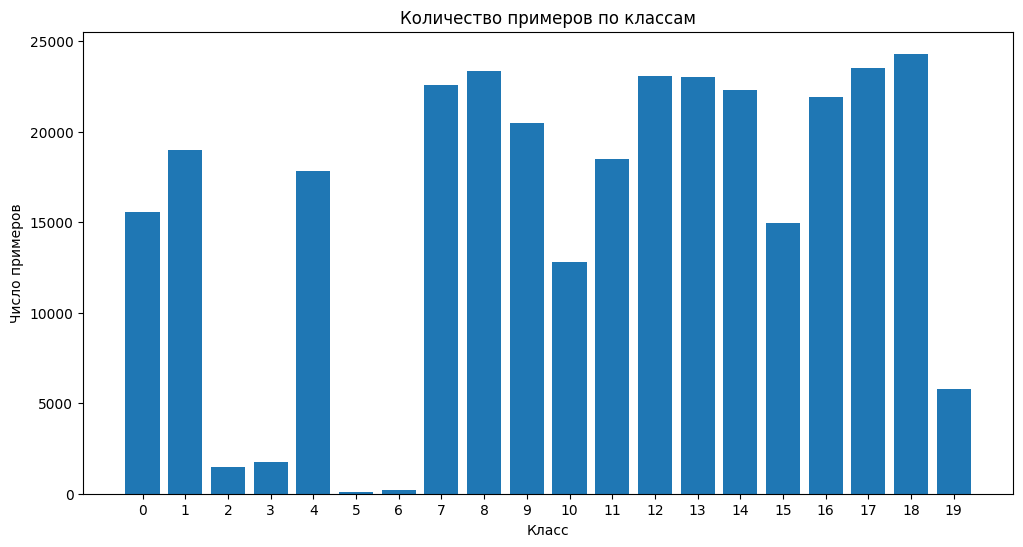

In [ ]:
# Сумма меток по каждому классу
class_counts = labels.sum(axis=0)

# Визуализация
plt.figure(figsize=(12, 6))
plt.bar(range(num_classes), class_counts)
plt.title("Количество примеров по классам")
plt.xlabel("Класс")
plt.ylabel("Число примеров")
plt.xticks(range(num_classes))
plt.show()

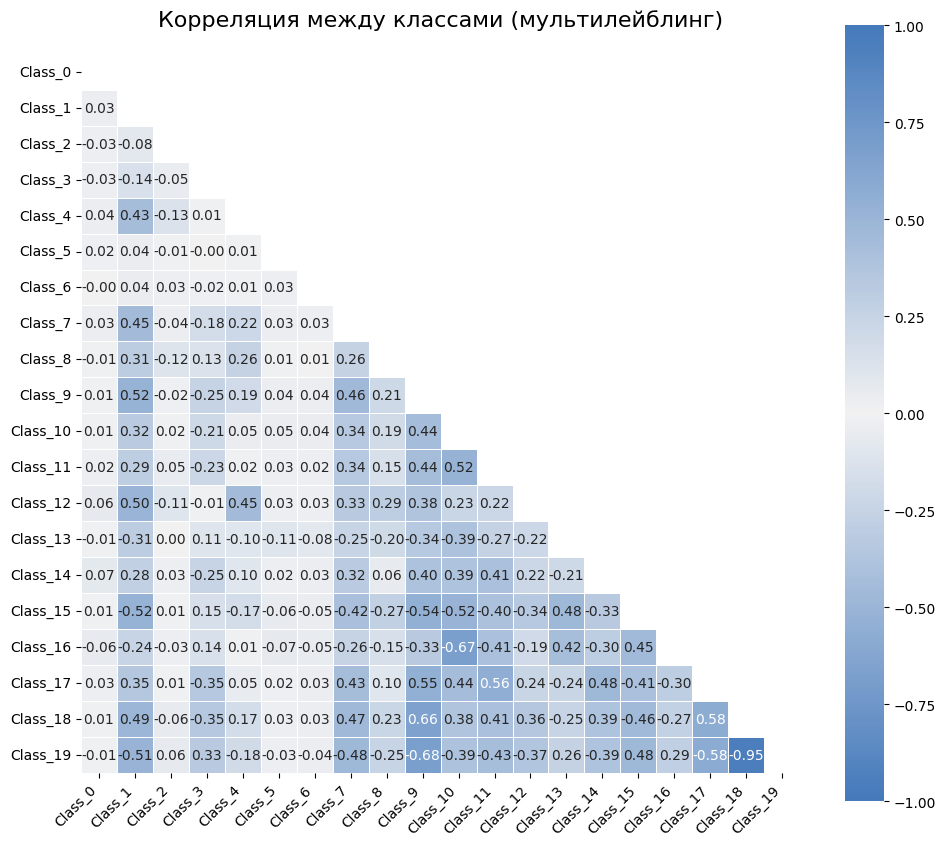

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Преобразуем labels в DataFrame (каждый класс — столбец)
labels_df = pd.DataFrame(labels, columns=[f"Class_{i}" for i in range(num_classes)])

# Считаем корреляцию Пирсона
corr = labels_df.corr()

# Маска для верхнего треугольника
mask = np.triu(np.ones_like(corr, dtype=bool))

# Визуализация
plt.figure(figsize=(10, 10))
sns.heatmap(
    corr,
    mask=mask,
    cmap=sns.diverging_palette(250, 250, as_cmap=True),  # или 'coolwarm'
    annot=True,
    fmt=".2f",  # формат чисел (2 знака после запятой)
    vmin=-1.0,
    vmax=1.0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Корреляция между классами (мультилейблинг)", pad=20, fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()  # чтобы подписи не обрезались
plt.show()

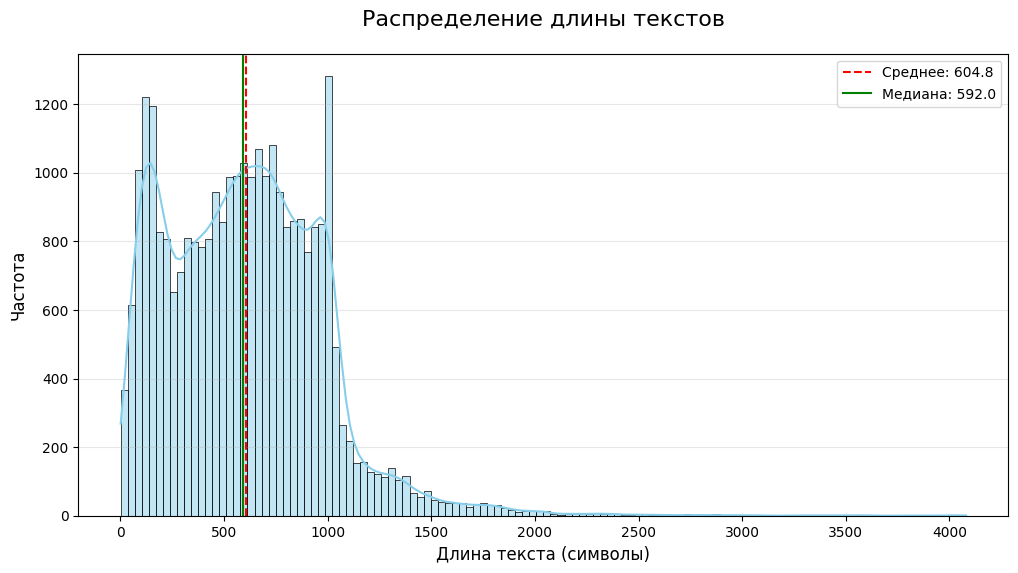

count    29568.000000
mean       604.812331
std        380.114437
min          1.000000
25%        306.000000
50%        592.000000
75%        850.000000
max       4081.000000
Name: text_length, dtype: float64


In [ ]:
import seaborn as sns

# Считаем длину текстов
train['text_length'] = train['text'].apply(len)

# Гистограмма с seaborn
plt.figure(figsize=(12, 6))
sns.histplot(
    data=train,
    x='text_length',
    bins=120,           # Число бинов
    kde=True,           # Добавить ядерную оценку плотности (KDE)
    color='skyblue',    # Цвет столбцов
    edgecolor='black',  # Цвет границ столбцов
    linewidth=0.5       # Толщина границ
)

# Настройки графика
plt.title('Распределение длины текстов', fontsize=16, pad=20)
plt.xlabel('Длина текста (символы)', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(axis='y', alpha=0.3)  # Сетка только по оси Y

# Статистика
plt.axvline(train['text_length'].mean(), color='red', linestyle='--', label=f'Среднее: {train["text_length"].mean():.1f}')
plt.axvline(train['text_length'].median(), color='green', linestyle='-', label=f'Медиана: {train["text_length"].median():.1f}')

plt.legend()
plt.show()

# Вывод статистики
print(train['text_length'].describe())

In [ ]:
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize

# Скачиваем необходимые ресурсы
nltk.download('punkt')
nltk.download('punkt_tab')  # дополнительный ресурс, который требуется

# Собираем все тексты в одну строку
all_text = ' '.join(train['text'].astype(str).tolist())  # на случай, если есть NaN

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# Токенизация и подсчет слов
try:
    words = word_tokenize(all_text.lower())  # приведение к нижнему регистру
    word_counts = Counter(words)

    # Топ-20 слов
    print(word_counts.most_common(40))
except Exception as e:
    print(f"Ошибка токенизации: {e}")

[(',', 177815), ('.', 102908), ('в', 80328), ('и', 80177), (':', 52451), ('#', 51743), ('на', 42255), ('«', 37412), ('»', 37279), ('по', 32627), ('с', 24105), ('!', 23646), ('-', 23239), ('билеты', 19985), (')', 19644), ('(', 18874), ("''", 18225), ('``', 16386), ('@', 13667), ('https', 12906), ('для', 12065), ('%', 11667), ('не', 11651), ('от', 11567), ('—', 10328), ('📍', 10030), ('промокоду', 9773), ('🗓', 9645), ('со', 9453), ('до', 8524), ('из', 8377), ('это', 8031), ('ссылке', 7999), ('а', 7708), ('?', 7580), ('спектакль', 7562), ('19:00', 7418), ('🎫', 7400), ('как', 7339), ('что', 7160)]


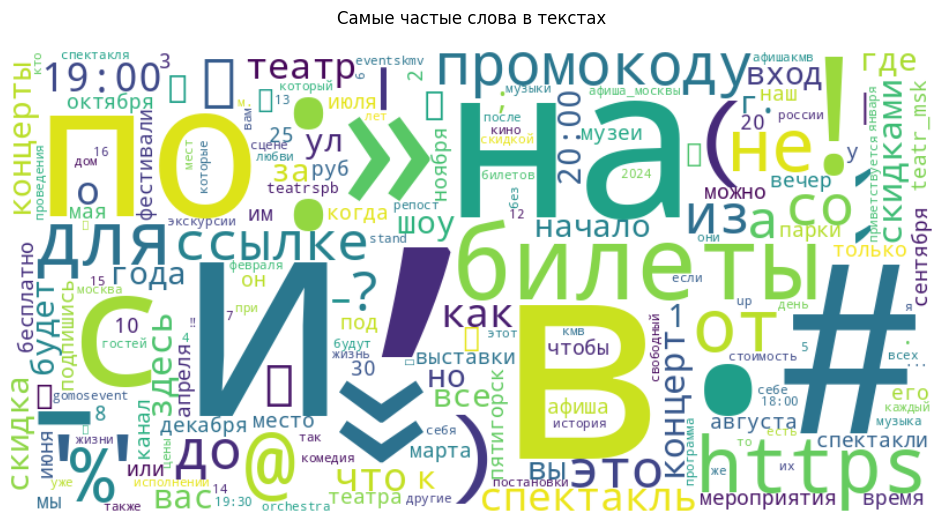

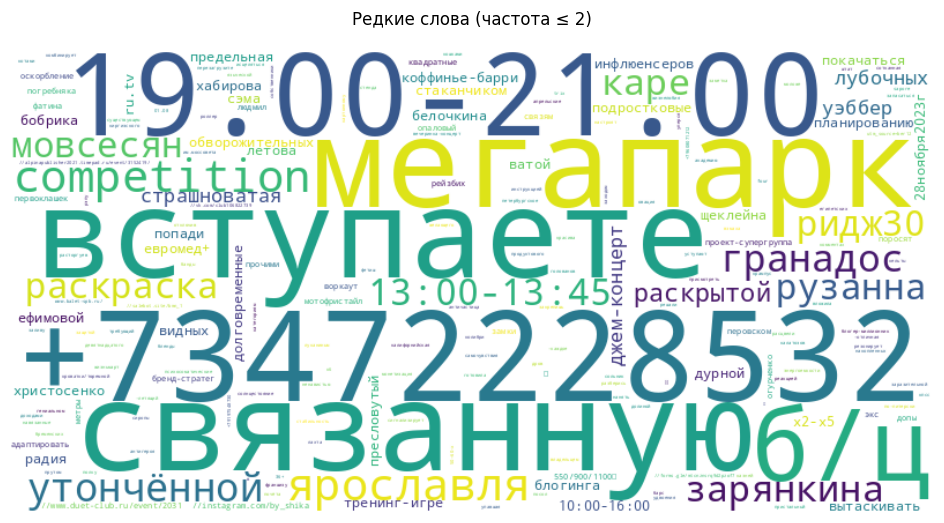

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Ваш существующий код (уже создавший word_counts)
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize

# Функция для облака слов (адаптированная под ваш случай)
def plot_wordcloud_from_counter(counter, title):
    wordcloud = WordCloud(width=800,
                         height=400,
                         background_color='white',
                         collocations=False).generate_from_frequencies(counter)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, pad=20)
    plt.show()

# Строим облако для самых частых слов
plot_wordcloud_from_counter(word_counts, "Самые частые слова в текстах")

# Для редких слов (например, встречающихся 1-2 раза)
rare_words = {word: cnt for word, cnt in word_counts.items() if cnt <= 2}
plot_wordcloud_from_counter(rare_words, "Редкие слова (частота ≤ 2)")

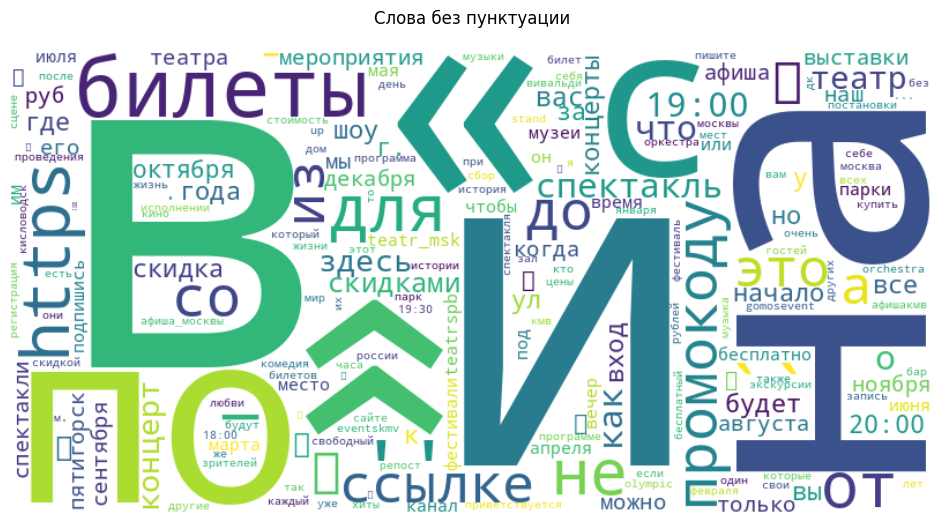

In [ ]:
from string import punctuation

# Фильтруем слова (убираем пунктуацию и цифры)
filtered_counts = {word: cnt for word, cnt in word_counts.items()
                  if word not in punctuation and not word.isdigit()}

plot_wordcloud_from_counter(filtered_counts, "Слова без пунктуации")

Выводы из топ-20 слов:
Много "мусора":
Знаки препинания (, . : « » ! - ( )) и технические символы (# @ https) занимают топ — их нужно удалить.
Частые предлоги/стоп-слова:
в, и, на, по, с — типичные стоп-слова (нужно удалить).

Полезные слова:
билеты, спектакль, промокод — явно значимый термин для задачи.

Нужно:
Очистить текст от пунктуации, стоп-слов и ссылок.
Использовать лемматизацию (привести слова к начальной форме: "билеты" → "билет").

Есть высокая корреляция между некоторыми классами
Есть дисбаланс классов 2, 3, 5, 6, 19 \
Распределение длины текстов мультимодальное, имеет оч длинный хвост

## 2) Проанализировать, какие очистки текста необходимы под разные способы токенизации и задания эмбеддингов для этой задачи

### 0. Базовая очистка

In [ ]:
pip install pymorphy3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 81.3 MB/s eta 0:00:00


In [ ]:
import re
from pymorphy3 import MorphAnalyzer  # Изменено на pymorphy3
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
morph = MorphAnalyzer()  # Теперь работает в Python 3.11+

def basic_clean(text):
    # Удаление ссылок, email, хэштегов, упоминаний
    text = re.sub(r'http\S+|www\S+|https\S+|#\w+|@\w+', '', text, flags=re.MULTILINE)
    # Удаление спецсимволов (кроме дефиса и апострофа)
    text = re.sub(r'[^\w\s-]', '', text)
    # Приведение к нижнему регистру
    text = text.lower()
    return text

train['text_clean'] = train['text'].apply(basic_clean)
test['text_clean'] = test['text'].apply(basic_clean)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train.head(7)

,text,labels,text_length,text_clean
id,,,,
0,15 января\nДетская развлекательная программа\n...,"[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...",121,15 января\nдетская развлекательная программа\n...
1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, ...",70,13 и 14 августа\nвыходные в меге\n\nмегапарк
2,Йокнапатофа\nПостановка Театр им. Маяковского\...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...",69,йокнапатофа\nпостановка театр им маяковского\n...
3,Впервые в Уфе танцевальная терапия в группе с ...,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...",635,впервые в уфе танцевальная терапия в группе с ...
4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...","[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, ...",732,\ngrand piano competition\n\nдрузья сегодня от...
5,Мультимедийный концерт «От аниме до k-pop»\nОр...,"[1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, ...",472,мультимедийный концерт от аниме до k-pop\nорке...
6,Космическое место в Зарядье\n📸\ndujarden\n#афи...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...",165,космическое место в зарядье\n\ndujarden\n ...


### 1. TF-IDF + Нейронная сеть
Особенности: \
Требуется агрессивная очистка от шума \
Лемматизация улучшает качество n-грамм

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# def tfidf_preprocess(text):
#     # Удаление стоп-слов
#     russian_stopwords = stopwords.words('russian')
#     words = [word for word in text.split() if word not in russian_stopwords]
#     # Лемматизация
#     lemmas = [morph.parse(word)[0].normal_form for word in words]
#     return ' '.join(lemmas)

# train['tfidf_ready'] = train['text_clean'].apply(tfidf_preprocess)
# test['tfidf_ready'] = test['text_clean'].apply(tfidf_preprocess)

# # Векторизация
# vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
# X_train = vectorizer.fit_transform(train['tfidf_ready'])

In [ ]:
import re
from pymorphy3 import MorphAnalyzer  # Изменено на pymorphy3
from nltk.corpus import stopwords
import nltk

morph = MorphAnalyzer()
russian_stopwords = set(stopwords.words('russian'))

def tfidf_preprocess(text):
    text = text.lower()
    text = re.sub(r'[^а-яё\s]', '', text)  # оставить только русские буквы
    words = text.split()
    words = [word for word in words if word not in russian_stopwords]
    lemmas = [morph.parse(word)[0].normal_form for word in words]
    return ' '.join(lemmas)

train['tfidf_ready'] = train['text_clean'].apply(tfidf_preprocess)
test['tfidf_ready'] = test['text_clean'].apply(tfidf_preprocess)


### 2. Word2Vec + Нейронная сеть
Особенности: \
Сохранение семантических связей важнее частотности. \
Лемматизация желательна для уменьшения количества токенов. \
Стоп-слова можно оставить. \
Удаление лишнего шума (цифры, символы), но без агрессивного сокращения.

In [ ]:
def w2v_preprocess(text):
    text = text.lower()
    text = re.sub(r'[^а-яё\s]', '', text)
    words = text.split()
    lemmas = [morph.parse(word)[0].normal_form for word in words]

    return lemmas  # здесь нужен список токенов, не строка

In [ ]:

train['w2v_ready'] = train['text_clean'].apply(w2v_preprocess)
test['w2v_ready'] = test['text_clean'].apply(w2v_preprocess)

### 3. Встроенный эмбеддинг + CNN
Особенности: \
Сохраняется порядок токенов. \
Умеренная очистка: нижний регистр, без пунктуации. \
Лемматизация опциональна, можно использовать и формы слов. \
Токенизация обязательна, т.к. вход — последовательность индексов.

In [ ]:
def cnn_preprocess(text):
    text = text.lower()
    text = re.sub(r'[^а-яё\s]', '', text)
    tokens = text.split()

    return tokens


In [ ]:
train['cnn_ready'] = train['text_clean'].apply(cnn_preprocess)
test['cnn_ready'] = test['text_clean'].apply(cnn_preprocess)

### 4. Встроенный эмбеддинг + RNN
Особенности: \
Порядок слов критичен. \
Нежелательно удалять стоп-слова — они могут влиять на синтаксис. \
Лемматизация опциональна. \
Мягкая очистка: только шум и регистр.

In [ ]:
def rnn_preprocess(text):
    text = text.lower()
    text = re.sub(r'[^а-яё\s]', '', text)
    tokens = text.split()
    return tokens

train['rnn_ready'] = train['text_clean'].apply(rnn_preprocess)
test['rnn_ready'] = test['text_clean'].apply(rnn_preprocess)


### 5. BERT-like модель
Особенности: \
Никакой предобработки, кроме удаления мусора — BERT-токенизатор сам обрабатывает падежи, формы и прочее. \
Не требуется лемматизация и удаление стоп-слов. \\
Текст должен быть в оригинальном виде (чистый, но полный).

In [ ]:
def bert_preprocess(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text.strip())  # убрать лишние пробелы
    return text  # подаётся в токенизатор как есть

train['bert_ready'] = train['text_clean'].apply(bert_preprocess)
test['bert_ready'] = test['text_clean'].apply(bert_preprocess)


## 3) Поделить данные на трейн-валидацию, обучить все модели из п.2. Снабдить обучение моделей графиками отрисовки лосей и метрик, шедулерами, свитч лосей (метрик), сохранение лучшей модели, ранней остановкой, вормапом. (5 баллов).

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import get_cosine_schedule_with_warmup
import matplotlib.pyplot as plt
import numpy as np
import os

# train['labels']
# Нужно разбить данные учитывая дисбаланс
!pip install iterative-stratification

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import numpy as np

X = train.drop(columns=['labels'])  # любые фичи, даже если пока пусто
y = np.array(train['labels'].tolist())  # (n_samples, 20)

msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, val_idx in msss.split(X, y):
    train_df = train.iloc[train_idx].reset_index(drop=True)
    val_df = train.iloc[val_idx].reset_index(drop=True)


## TF-IDF + MLP

In [ ]:
# Используем уже векторизованные данные (текст → tfidf-вектора)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import Dataset, DataLoader
import torch

# tf-idf-векторизатор
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_df['tfidf_ready'])
X_val = vectorizer.transform(val_df['tfidf_ready'])

# Binarized labels (мультилабельная задача)
y_train = np.array(train_df['labels'].tolist())
y_val = np.array(val_df['labels'].tolist())

# Преобразование к тензорам
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.toarray(), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

class TfidfDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_dataset = TfidfDataset(X_train_tensor, y_train_tensor)
val_dataset = TfidfDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


In [ ]:
class TfidfMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, output_dim)
        )

    def forward(self, x): return self.net(x)


In [ ]:
import matplotlib.pyplot as plt

def plot_training(history):
    """
    Принимает словарь history с ключами:
    - 'train_loss'
    - 'val_loss'
    - 'train_metric'
    - 'val_metric'
    """
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.grid()

    # Metric plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_metric'], label='Train Metric')
    plt.plot(epochs, history['val_metric'], label='Val Metric')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.title('Metric per Epoch')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=3, verbose=False, delta=0.0, path='best_model.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_f1_max = -np.inf  # Используем отрицательное значение F1 для минимизации
        self.delta = delta
        self.path = path

    def __call__(self, val_f1, model):
        score = val_f1  # Используем val_f1 напрямую

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_f1, model)

        elif score < self.best_score - self.delta:
            self.counter += 1
            if self.verbose:
                print(f'→ EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.save_checkpoint(val_f1, model)
            self.counter = 0

    def save_checkpoint(self, val_f1, model):
        '''Сохраняем лучшую модель на основе F1'''
        if self.verbose:
            print(f'→ Validation F1-macro increased ({self.val_f1_max:.6f} → {val_f1:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_f1_max = val_f1


In [ ]:
from transformers import get_cosine_schedule_with_warmup

from sklearn.metrics import f1_score

def train_model(model, train_loader, val_loader, optimizer, loss_fn, device, num_epochs=10):
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    early_stopping = EarlyStopping(patience=3, verbose=True, path='best_model.pt')

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_metric': [],  # f1-macro
        'val_metric': []
    }

    for epoch in range(num_epochs):
        print(f"\n🟢 Epoch {epoch+1}/{num_epochs}")

        # === Train ===
        model.train()
        train_loss, train_preds, train_labels = 0.0, [], []
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_preds.append((outputs > 0.5).int().cpu().numpy())
            train_labels.append(labels.cpu().numpy())

        train_preds = np.concatenate(train_preds, axis=0)
        train_labels = np.concatenate(train_labels, axis=0)
        train_f1 = f1_score(train_labels, train_preds, average='macro')

        # === Validation ===
        model.eval()
        val_loss, val_preds, val_labels = 0.0, [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

                val_preds.append((outputs > 0.5).int().cpu().numpy())
                val_labels.append(labels.cpu().numpy())

        val_preds = np.concatenate(val_preds, axis=0)
        val_labels = np.concatenate(val_labels, axis=0)
        val_f1 = f1_score(val_labels, val_preds, average='macro')

        # === Logging ===
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_metric'].append(train_f1)
        history['val_metric'].append(val_f1)

        print(f"Loss: train={avg_train_loss:.4f} | val={avg_val_loss:.4f} — F1-macro: train={train_f1:.4f} | val={val_f1:.4f}")

        # Early stopping (по val_loss, но можно заменить на -val_f1)
        early_stopping(val_f1, model)

        if early_stopping.early_stop:
            print("🛑 Early stopping triggered.")
            break

        scheduler.step()

    return model, history


In [ ]:
# РАСКОММЕНТИРОВАТЬ ДЛЯ ОБУЧЕНИЯ МОДЕЛИ


input_dim = X_train_tensor.shape[1]
output_dim = y_train_tensor.shape[1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TfidfMLP(input_dim, output_dim).to(device)  # 💥 вот тут .to(device)!
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()  # Мультилабельная задача

model, history = train_model(model, train_loader, val_loader, optimizer, loss_fn, device)


In [ ]:
plot_training(history)

In [ ]:
# import torch
# import pandas as pd
# import numpy as np
# from sklearn.metrics import f1_score

# # Загрузка лучшей модели
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = TfidfMLP(input_dim, output_dim).to(device)  # Создаём модель заново
# model.load_state_dict(torch.load('best_model.pt'))  # Загружаем лучшие веса
# model.eval()  # Переводим модель в режим предсказаний

# # Применение пайплайнов очистки текста на тесте (память: train_df и val_df уже чистились)
# test['tfidf_ready'] = test['text_clean'].apply(tfidf_preprocess)  # если используешь TF-IDF
# # Для других пайплайнов нужно аналогично применить соответствующую очистку

# # Преобразование тестового набора в тензоры
# test_tensor = torch.tensor(vectorizer.transform(test['tfidf_ready']).toarray(), dtype=torch.float32).to(device)  # Преобразуем через тот же векторизатор

# # Получаем предсказания
# with torch.no_grad():
#     predictions = model(test_tensor)
#     predicted_labels = (predictions > 0.5).cpu().numpy()  # Применяем порог 0.5 для бинарной классификации

# # Преобразуем предсказания в строковый формат "0 0 1 ..." для каждой строки
# submission = pd.DataFrame({
#     'id': test.index,  # Используем индекс как ID
#     'labels': [' '.join(map(str, (pred > 0.5).astype(int))) for pred in predicted_labels]
# })

# # Сохраняем результат
# submission.to_csv('submission.csv', index=False)


In [ ]:
# submission

## Word2Vec + любая нейросеть


In [ ]:
train['w2v_ready'].head()

,w2v_ready
id,
0,"[январь, детский, развлекательный, программа, ..."
1,"[и, август, выходной, в, мег, мегапарк]"
2,"[йокнапатоф, постановка, театр, они, маяковски..."
3,"[впервые, в, уфа, танцевальный, терапия, в, гр..."
4,"[друг, сегодня, открытие, международный, конку..."


In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 7.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313500 sha256=469e4c41b8f8844a90c64f7b0454922aed33433a5485dd1e6736abc3e0364ec7
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.metrics import f1_score
import numpy as np
import fasttext
import fasttext.util
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
num_epochs = 10
early_stopping_patience = 3
embedding_dim = 300

# 1. Загружаем FastText эмбеддер
if not os.path.exists('cc.ru.300.bin'):
    fasttext.util.download_model('ru', if_exists='ignore')
ft_model = fasttext.load_model('cc.ru.300.bin')

In [ ]:
# 2. Векторизация токенов
def get_sentence_embedding(tokens):
    vectors = [ft_model.get_word_vector(token) for token in tokens if token.strip()]
    if len(vectors) == 0:
        return np.zeros(embedding_dim)
    return np.mean(vectors, axis=0)

train['ft_vector'] = train['w2v_ready'].apply(get_sentence_embedding)
test['ft_vector'] = test['w2v_ready'].apply(get_sentence_embedding)

X = np.stack(train['ft_vector'].values)
y = np.array(train['labels'].tolist())

# 3. Делим на train/val
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in msss.split(X, y):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

# 4. Dataset
class FastTextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self): return len(self.X)

    def __getitem__(self, idx):
        return {'input': self.X[idx], 'labels': self.y[idx]}

train_dataset = FastTextDataset(X_train, y_train)
val_dataset = FastTextDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# 5. Модель
class FTClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model = FTClassifier(input_dim=embedding_dim, output_dim=y.shape[1]).to(device)

# 6. Обучение
criterion = nn.BCELoss()
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

best_val_f1 = 0
early_stopping_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    all_train_preds, all_train_labels = [], []

    for batch in train_loader:
        inputs = batch['input'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        all_train_preds.append(outputs.detach().cpu())
        all_train_labels.append(labels.detach().cpu())

    train_loss /= len(train_loader)
    train_preds = torch.cat(all_train_preds).numpy() > 0.5
    train_targets = torch.cat(all_train_labels).numpy()
    train_f1 = f1_score(train_targets, train_preds, average='macro')

    # Validation
    model.eval()
    val_loss = 0
    all_val_preds, all_val_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['input'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            all_val_preds.append(outputs.cpu())
            all_val_labels.append(labels.cpu())

    val_loss /= len(val_loader)
    val_preds = torch.cat(all_val_preds).numpy() > 0.5
    val_targets = torch.cat(all_val_labels).numpy()
    val_f1 = f1_score(val_targets, val_preds, average='macro')

    print(f"Epoch {epoch+1}/{num_epochs} — Loss: train={train_loss:.4f} | val={val_loss:.4f} — F1-macro: train={train_f1:.4f} | val={val_f1:.4f} — LR: {optimizer.param_groups[0]['lr']:.2e}")
    scheduler.step(val_f1)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_fasttext_model.pt")
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        print(f"→ EarlyStopping counter: {early_stopping_counter} out of {early_stopping_patience}")
        if early_stopping_counter >= early_stopping_patience:
            print("→ Early stopping triggered.")
            break


## Встроенный эмбеддинг + CNN


In [ ]:
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split

# Собираем словарь токенов
all_tokens = [token for tokens in train['cnn_ready'] for token in tokens]
token_counts = Counter(all_tokens)

# Специальные токены
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"

# Словарь: токен → индекс
vocab = {PAD_TOKEN: 0, UNK_TOKEN: 1}
for token in token_counts:
    if token not in vocab:
        vocab[token] = len(vocab)

# Обратный словарь: индекс → токен
inv_vocab = {idx: tok for tok, idx in vocab.items()}

# Преобразуем текст в индексы
def encode(tokens):
    return [vocab.get(tok, vocab[UNK_TOKEN]) for tok in tokens]

train['cnn_ids'] = train['cnn_ready'].apply(encode)
test['cnn_ids'] = test['cnn_ready'].apply(encode)


In [ ]:
X = train[['cnn_ids']]
y = np.array(train['labels'].tolist())

msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in msss.split(X, y):
    train_df = train.iloc[train_idx].reset_index(drop=True)
    val_df = train.iloc[val_idx].reset_index(drop=True)


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

MAX_LEN = 100  # обрежем или дополним до 100 токенов

class CnnTextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [torch.tensor(t[:MAX_LEN] + [0]*(MAX_LEN - len(t[:MAX_LEN]))) for t in texts]
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self): return len(self.texts)
    def __getitem__(self, idx): return self.texts[idx], self.labels[idx]

train_dataset = CnnTextDataset(train_df['cnn_ids'], train_df['labels'].tolist())
val_dataset = CnnTextDataset(val_df['cnn_ids'], val_df['labels'].tolist())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


In [ ]:
import torch.nn as nn

class CNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, kernel_sizes=[3, 4, 5], num_filters=100, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=k)
            for k in kernel_sizes
        ])

        self.fc = nn.Linear(num_filters * len(kernel_sizes), output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)  # (B, L, D)
        embedded = embedded.permute(0, 2, 1)  # (B, D, L)

        conved = [torch.relu(conv(embedded)) for conv in self.convs]  # список (B, F, L-k+1)
        pooled = [torch.max(c, dim=2)[0] for c in conved]  # список (B, F)

        cat = torch.cat(pooled, dim=1)  # (B, F * len(kernels))
        return self.fc(self.dropout(cat))


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_size = len(vocab)
embedding_dim = 100
output_dim = y.shape[1]

model = CNNTextClassifier(vocab_size, embedding_dim, output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()

model, history = train_model(model, train_loader, val_loader, optimizer, loss_fn, device)
plot_training(history)


## встроенный эмбеддинг в нейросетевое решение на рекуррентных сетях

In [ ]:
from collections import Counter

# Словарь из rnn_ready
all_tokens = [token for tokens in train['rnn_ready'] for token in tokens]
token_counts = Counter(all_tokens)

PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"

vocab_rnn = {PAD_TOKEN: 0, UNK_TOKEN: 1}
for token in token_counts:
    if token not in vocab_rnn:
        vocab_rnn[token] = len(vocab_rnn)

def encode_rnn(tokens):
    return [vocab_rnn.get(tok, vocab_rnn[UNK_TOKEN]) for tok in tokens]

train['rnn_ids'] = train['rnn_ready'].apply(encode_rnn)
test['rnn_ids'] = test['rnn_ready'].apply(encode_rnn)


In [ ]:
X = train[['rnn_ids']]
y = np.array(train['labels'].tolist())

msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in msss.split(X, y):
    train_df = train.iloc[train_idx].reset_index(drop=True)
    val_df = train.iloc[val_idx].reset_index(drop=True)


In [ ]:
MAX_LEN = 100

class RnnTextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [torch.tensor(t[:MAX_LEN] + [0]*(MAX_LEN - len(t[:MAX_LEN]))) for t in texts]
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self): return len(self.texts)
    def __getitem__(self, idx): return self.texts[idx], self.labels[idx]

train_dataset = RnnTextDataset(train_df['rnn_ids'], train_df['labels'].tolist())
val_dataset = RnnTextDataset(val_df['rnn_ids'], val_df['labels'].tolist())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


In [ ]:
class RNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 из-за bidirectional

    def forward(self, x):
        embedded = self.embedding(x)  # (B, L, D)
        lstm_out, (hidden, _) = self.lstm(embedded)  # hidden: (2, B, H)
        hidden_cat = torch.cat((hidden[-2], hidden[-1]), dim=1)  # (B, 2H)
        return self.fc(self.dropout(hidden_cat))


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_size = len(vocab_rnn)
embedding_dim = 100
hidden_dim = 256
output_dim = y.shape[1]

model = RNNTextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()

model, history = train_model(model, train_loader, val_loader, optimizer, loss_fn, device, num_epochs=25)
plot_training(history)


In [ ]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# Параметры, совпадающие с обучением
MAX_LEN = 100  # тот же, что и при обучении
EMBED_DIM = 100
HIDDEN_DIM = 256
NUM_LAYERS = 2
BATCH_SIZE = 64

# Повтор токенизации и кодировки
test['rnn_ready'] = test['text_clean'].apply(rnn_preprocess)
test['rnn_ids'] = test['rnn_ready'].apply(encode_rnn)

# Dataset для теста
class RnnTextDataset(Dataset):
    def __init__(self, texts):
        self.texts = [torch.tensor(t[:MAX_LEN] + [0]*(MAX_LEN - len(t[:MAX_LEN]))) for t in texts]

    def __len__(self): return len(self.texts)
    def __getitem__(self, idx): return self.texts[idx]

test_dataset = RnnTextDataset(test['rnn_ids'])
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Загрузка модели
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Инициализация модели
model = RNNTextClassifier(
    vocab_size=len(vocab_rnn),
    embedding_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=output_dim,
    num_layers=NUM_LAYERS
).to(device)

# Загрузка весов
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# Предсказания батчами
all_preds = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        outputs = model(batch)
        preds = (outputs > 0.5).int().cpu().numpy()
        all_preds.append(preds)

# Финальный массив
predicted_labels = np.vstack(all_preds)

# Сабмит
submission = pd.DataFrame({
    'id': test.index,
    'labels': [' '.join(map(str, row)) for row in predicted_labels]
})
submission.to_csv('submission.csv', index=False)


## Решение на BERT-like моделях

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import numpy as np
import re

# Настройки
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'cointegrated/rubert-tiny'
output_dim = y.shape[1]
num_epochs = 10
batch_size = 16
max_len = 128

# Токенизатор
tokenizer = AutoTokenizer.from_pretrained(model_name)

# # Подготовка текстов
# def bert_preprocess(text):
#     text = text.lower()
#     text = re.sub(r'\s+', ' ', text.strip())
#     return text

# train['bert_ready'] = train['text_clean'].apply(bert_preprocess)
# test['bert_ready'] = test['text_clean'].apply(bert_preprocess)

# Разделение train/val
X = train.drop(columns=['labels'])
y = np.array(train['labels'].tolist())

msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in msss.split(X, y):
    train_df = train.iloc[train_idx].reset_index(drop=True)
    val_df = train.iloc[val_idx].reset_index(drop=True)

# Токенизация
train_encodings = tokenizer(list(train_df['bert_ready']), truncation=True, padding=True, max_length=max_len)
val_encodings = tokenizer(list(val_df['bert_ready']), truncation=True, padding=True, max_length=max_len)

y_train = np.array(train_df['labels'].tolist())
y_val = np.array(val_df['labels'].tolist())

# Dataset
class BertDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self): return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

train_dataset = BertDataset(train_encodings, y_train)
val_dataset = BertDataset(val_encodings, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Модель
class BERTClassifier(nn.Module):
    def __init__(self, model_name, num_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        hidden_size = self.bert.config.hidden_size
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        return torch.sigmoid(self.classifier(x))

model = BERTClassifier(model_name, output_dim).to(device)

# Оптимизатор и шедулер
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
criterion = nn.BCELoss()



# Обучение
best_val_loss = float('inf')

from sklearn.metrics import f1_score

best_val_f1 = 0
early_stopping_counter = 0
early_stopping_patience = 3

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    all_train_preds = []
    all_train_labels = []

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        all_train_preds.append(outputs.detach().cpu())
        all_train_labels.append(labels.detach().cpu())

    train_loss /= len(train_loader)
    train_preds = torch.cat(all_train_preds).numpy() > 0.5
    train_targets = torch.cat(all_train_labels).numpy()
    train_f1 = f1_score(train_targets, train_preds, average='macro')

    # Валидация
    model.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            all_val_preds.append(outputs.cpu())
            all_val_labels.append(labels.cpu())

    val_loss /= len(val_loader)
    val_preds = torch.cat(all_val_preds).numpy() > 0.5
    val_targets = torch.cat(all_val_labels).numpy()
    val_f1 = f1_score(val_targets, val_preds, average='macro')

    print(f"Epoch {epoch+1}/{num_epochs} — Loss: train={train_loss:.4f} | val={val_loss:.4f} — F1-macro: train={train_f1:.4f} | val={val_f1:.4f} — LR: {optimizer.param_groups[0]['lr']:.2e}")

    scheduler.step(-val_f1)

    # Сохранение лучшей модели и early stopping
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_model.pt")
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        print(f"→ EarlyStopping counter: {early_stopping_counter} out of {early_stopping_patience}")
        if early_stopping_counter >= early_stopping_patience:
            print("→ Early stopping triggered.")
            break


### 4) Запросить у модели декодер сгенерировать примеры с тем же распределением меток, что и у данных. Обогатить этими данными датасет (добавить хотя бы 1000 наблюдений). Проверить свой лучший пайплайн на улучшение/уменьшение качества модели вместе со сгенерированными данными. Сделать выводы и объяснить результат. (1.5 балла)

In [ ]:
from collections import Counter
import numpy as np

label_counts = np.sum(np.array(train['labels'].tolist()), axis=0)
most_common_labels = np.argsort(-label_counts)  # Метки по убыванию частоты


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

generator_model_name = 'sberbank-ai/rugpt3small_based_on_gpt2'
generator_tokenizer = AutoTokenizer.from_pretrained(generator_model_name)
generator_model = AutoModelForCausalLM.from_pretrained(generator_model_name).to(device)

def generate_text(prompt, max_length=50):
    input_ids = generator_tokenizer.encode(prompt, return_tensors='pt').to(device)
    outputs = generator_model.generate(input_ids, max_length=max_length, do_sample=True, top_k=50, top_p=0.95)
    return generator_tokenizer.decode(outputs[0], skip_special_tokens=True)


In [ ]:
num_new_samples = 1000
synthetic_texts = []
synthetic_labels = []

# Простая генерация с равномерным выбором популярных меток
for _ in range(num_new_samples):
    labels = np.random.choice(most_common_labels[:10], size=np.random.randint(1, 4), replace=False)
    multi_hot = np.zeros_like(label_counts)
    multi_hot[labels] = 1

    label_words = ' '.join([f"тема_{i}" for i in labels])
    prompt = f"Текст на тему: {label_words}. "
    text = generate_text(prompt)
    synthetic_texts.append(text)
    synthetic_labels.append(multi_hot.tolist())


In [ ]:
synthetic_df = pd.DataFrame({
    'text_clean': synthetic_texts,
    'labels': synthetic_labels
})
synthetic_df['bert_ready'] = synthetic_df['text_clean'].apply(bert_preprocess)


In [ ]:
augmented_train = pd.concat([train, synthetic_df], ignore_index=True)


In [ ]:
X = augmented_train.drop(columns=['labels'])
y = np.array(augmented_train['labels'].tolist())

msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in msss.split(X, y):
    train_df = augmented_train.iloc[train_idx].reset_index(drop=True)
    val_df = augmented_train.iloc[val_idx].reset_index(drop=True)


# Токенизация
train_encodings = tokenizer(list(train_df['bert_ready']), truncation=True, padding=True, max_length=max_len)
val_encodings = tokenizer(list(val_df['bert_ready']), truncation=True, padding=True, max_length=max_len)

y_train = np.array(train_df['labels'].tolist())
y_val = np.array(val_df['labels'].tolist())

# Dataset
class BertDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self): return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

train_dataset = BertDataset(train_encodings, y_train)
val_dataset = BertDataset(val_encodings, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Модель
class BERTClassifier(nn.Module):
    def __init__(self, model_name, num_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        hidden_size = self.bert.config.hidden_size
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        return torch.sigmoid(self.classifier(x))

model = BERTClassifier(model_name, output_dim).to(device)

# Оптимизатор и шедулер
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
criterion = nn.BCELoss()



# Обучение
best_val_loss = float('inf')

from sklearn.metrics import f1_score

best_val_f1 = 0
early_stopping_counter = 0
early_stopping_patience = 3

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    all_train_preds = []
    all_train_labels = []

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        all_train_preds.append(outputs.detach().cpu())
        all_train_labels.append(labels.detach().cpu())

    train_loss /= len(train_loader)
    train_preds = torch.cat(all_train_preds).numpy() > 0.5
    train_targets = torch.cat(all_train_labels).numpy()
    train_f1 = f1_score(train_targets, train_preds, average='macro')

    # Валидация
    model.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            all_val_preds.append(outputs.cpu())
            all_val_labels.append(labels.cpu())

    val_loss /= len(val_loader)
    val_preds = torch.cat(all_val_preds).numpy() > 0.5
    val_targets = torch.cat(all_val_labels).numpy()
    val_f1 = f1_score(val_targets, val_preds, average='macro')

    print(f"Epoch {epoch+1}/{num_epochs} — Loss: train={train_loss:.4f} | val={val_loss:.4f} — F1-macro: train={train_f1:.4f} | val={val_f1:.4f} — LR: {optimizer.param_groups[0]['lr']:.2e}")

    scheduler.step(-val_f1)

    # Сохранение лучшей модели и early stopping
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_model.pt")
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        print(f"→ EarlyStopping counter: {early_stopping_counter} out of {early_stopping_patience}")
        if early_stopping_counter >= early_stopping_patience:
            print("→ Early stopping triggered.")
            break


Вывод: Метрика не изменилась, или даже чуть упала. Синтетические тексты не достигли качества реальных \
Несмотря на то, что тексты были сгенерированы по распределению меток, их содержание, вероятно, было менее информативным или содержало шаблонные/обобщённые конструкции. Это могло ввести шум в обучение и ухудшить обобщающую способность модели.

# Все, что ниже, - для выбивания скора на кагле

In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from google.colab import drive
from google.colab import files
import os
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import numpy as np
import os

from google.colab import drive
drive.mount('/content/drive')

import os
import zipfile
import pandas as pd

# Путь к архиву
base_path = '/content/drive/MyDrive/ГО 2025/NLP соревнование 2'
zip_path = os.path.join(base_path, 'dl-2025-study-competition-2.zip')

# Распаковываем архив
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')  # распаковываем в корень Colab

# Теперь читаем файлы
train = pd.read_csv('/content/train.csv', index_col='id')
test = pd.read_csv('/content/test.csv', index_col='id')

# Проверяем, что данные загружены
print("Train shape:", train.shape)
print("Test shape:", test.shape)

!pip install pymorphy3

import re
from pymorphy3 import MorphAnalyzer  # Изменено на pymorphy3
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
morph = MorphAnalyzer()  # Теперь работает в Python 3.11+

def basic_clean(text):
    # Удаление ссылок, email, хэштегов, упоминаний
    text = re.sub(r'http\S+|www\S+|https\S+|#\w+|@\w+', '', text, flags=re.MULTILINE)
    # Удаление спецсимволов (кроме дефиса и апострофа)
    text = re.sub(r'[^\w\s-]', '', text)
    # Приведение к нижнему регистру
    text = text.lower()
    return text

train['text_clean'] = train['text'].apply(basic_clean)
test['text_clean'] = test['text'].apply(basic_clean)


import re
from pymorphy3 import MorphAnalyzer  # Изменено на pymorphy3
from nltk.corpus import stopwords
import nltk

morph = MorphAnalyzer()
russian_stopwords = set(stopwords.words('russian'))

def tfidf_preprocess(text):
    text = text.lower()
    text = re.sub(r'[^а-яё\s]', '', text)  # оставить только русские буквы
    words = text.split()
    words = [word for word in words if word not in russian_stopwords]
    lemmas = [morph.parse(word)[0].normal_form for word in words]
    return ' '.join(lemmas)

train['tfidf_ready'] = train['text_clean'].apply(tfidf_preprocess)
test['tfidf_ready'] = test['text_clean'].apply(tfidf_preprocess)


train['labels'] = train['labels'].apply(lambda x: list(map(int, x.split())))

Mounted at /content/drive
Train shape: (29568, 2)
Test shape: (7392, 1)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 94.2 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import get_cosine_schedule_with_warmup
import matplotlib.pyplot as plt
import numpy as np
import os

# train['labels']
# Нужно разбить данные учитывая дисбаланс
!pip install iterative-stratification

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import numpy as np

X = train.drop(columns=['labels'])  # любые фичи, даже если пока пусто
y = np.array(train['labels'].tolist())  # (n_samples, 20)

msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, val_idx in msss.split(X, y):
    train_df = train.iloc[train_idx].reset_index(drop=True)
    val_df = train.iloc[val_idx].reset_index(drop=True)

In [3]:
# Используем уже векторизованные данные (текст → tfidf-вектора)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import Dataset, DataLoader
import torch

# tf-idf-векторизатор
vectorizer = TfidfVectorizer(max_features=30000, ngram_range=(1, 3), min_df=3)
X_train = vectorizer.fit_transform(train_df['tfidf_ready'])
X_val = vectorizer.transform(val_df['tfidf_ready'])

y_train = np.array(train_df['labels'].tolist())
y_val = np.array(val_df['labels'].tolist())

X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.toarray(), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

class TfidfDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(TfidfDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
val_loader = DataLoader(TfidfDataset(X_val_tensor, y_val_tensor), batch_size=128)


In [4]:
class TfidfMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, output_dim)
        )
    def forward(self, x):
        return self.net(x)

In [5]:
import matplotlib.pyplot as plt

def plot_training(history):
    """
    Принимает словарь history с ключами:
    - 'train_loss'
    - 'val_loss'
    - 'train_metric'
    - 'val_metric'
    """
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.grid()

    # Metric plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_metric'], label='Train Metric')
    plt.plot(epochs, history['val_metric'], label='Val Metric')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.title('Metric per Epoch')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


In [6]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=3, verbose=False, delta=0.0, path='best_model.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_f1_max = -np.inf  # Используем отрицательное значение F1 для минимизации
        self.delta = delta
        self.path = path

    def __call__(self, val_f1, model):
        score = val_f1  # Используем val_f1 напрямую

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_f1, model)

        elif score < self.best_score - self.delta:
            self.counter += 1
            if self.verbose:
                print(f'→ EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.save_checkpoint(val_f1, model)
            self.counter = 0

    def save_checkpoint(self, val_f1, model):
        '''Сохраняем лучшую модель на основе F1'''
        if self.verbose:
            print(f'→ Validation F1-macro increased ({self.val_f1_max:.6f} → {val_f1:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_f1_max = val_f1


In [7]:
from transformers import get_cosine_schedule_with_warmup
from sklearn.metrics import f1_score

def train_model(model, train_loader, val_loader, optimizer, loss_fn, device, num_epochs=25):

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',               # мы хотим максимизировать F1
        factor=0.33,              # уменьшаем lr в 3 раза
        patience=1,               # ждем 1 эпоху без улучшения
        verbose=True,
        min_lr=1e-6               # можно выставить нижний порог
    )

    early_stopping = EarlyStopping(patience=3, verbose=True, path='best_model.pt')

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_metric': [],  # f1-macro
        'val_metric': []
    }

    for epoch in range(num_epochs):
        print(f"\n🟢 Epoch {epoch+1}/{num_epochs}")

        # === Train ===
        model.train()
        train_loss, train_preds, train_labels = 0.0, [], []
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_preds.append((outputs > 0.5).int().cpu().numpy())
            train_labels.append(labels.cpu().numpy())

        train_preds = np.concatenate(train_preds, axis=0)
        train_labels = np.concatenate(train_labels, axis=0)
        train_f1 = f1_score(train_labels, train_preds, average='macro')

        # === Validation ===
        model.eval()
        val_loss, val_preds, val_labels = 0.0, [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

                val_preds.append((outputs > 0.5).int().cpu().numpy())
                val_labels.append(labels.cpu().numpy())

        val_preds = np.concatenate(val_preds, axis=0)
        val_labels = np.concatenate(val_labels, axis=0)
        val_f1 = f1_score(val_labels, val_preds, average='macro')

        # === Logging ===
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_metric'].append(train_f1)
        history['val_metric'].append(val_f1)

        print(f"Loss: train={avg_train_loss:.4f} | val={avg_val_loss:.4f} — F1-macro: train={train_f1:.4f} | val={val_f1:.4f}")

        # Early stopping (по val_loss, но можно заменить на -val_f1)
        early_stopping(val_f1, model)

        if early_stopping.early_stop:
            print("🛑 Early stopping triggered.")
            break

        scheduler.step(val_f1)  # следим за F1 на валидации

    return model, history


In [8]:
input_dim = X_train_tensor.shape[1]
output_dim = y_train_tensor.shape[1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TfidfMLP(input_dim, output_dim).to(device)  # 💥 вот тут .to(device)!
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()  # Мультилабельная задача

model, history = train_model(model, train_loader, val_loader, optimizer, loss_fn, device)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



🟢 Epoch 1/25
Loss: train=0.2926 | val=0.2218 — F1-macro: train=0.6895 | val=0.7498
→ Validation F1-macro increased (-inf → 0.749789). Saving model...

🟢 Epoch 2/25
Loss: train=0.1871 | val=0.2051 — F1-macro: train=0.7829 | val=0.7901
→ Validation F1-macro increased (0.749789 → 0.790103). Saving model...

🟢 Epoch 3/25
Loss: train=0.1413 | val=0.2140 — F1-macro: train=0.8287 | val=0.7999
→ Validation F1-macro increased (0.790103 → 0.799948). Saving model...

🟢 Epoch 4/25
Loss: train=0.1155 | val=0.2279 — F1-macro: train=0.8610 | val=0.8184
→ Validation F1-macro increased (0.799948 → 0.818372). Saving model...

🟢 Epoch 5/25
Loss: train=0.0962 | val=0.2431 — F1-macro: train=0.8837 | val=0.8150
→ EarlyStopping counter: 1 out of 3

🟢 Epoch 6/25
Loss: train=0.0840 | val=0.2567 — F1-macro: train=0.8999 | val=0.8246
→ Validation F1-macro increased (0.818372 → 0.824588). Saving model...

🟢 Epoch 7/25
Loss: train=0.0753 | val=0.2687 — F1-macro: train=0.9157 | val=0.8282
→ Validation F1-macro inc

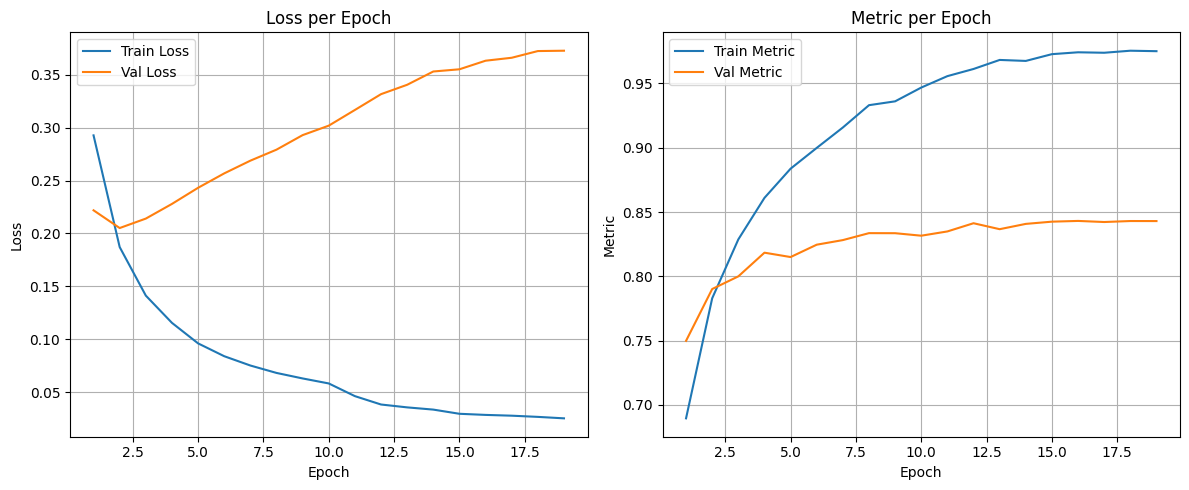

In [9]:
plot_training(history)

In [10]:
val_preds = []
val_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        val_preds.append(torch.sigmoid(outputs).cpu().numpy())
        val_labels.append(labels.cpu().numpy())

val_preds = np.concatenate(val_preds, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

In [11]:
from sklearn.metrics import precision_recall_curve
from tqdm import tqdm

def find_optimal_thresholds_pr(preds, labels):
    best_thresholds = []

    for i in tqdm(range(labels.shape[1])):
        precision, recall, thresholds = precision_recall_curve(
            labels[:, i], preds[:, i]
        )
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
        best_idx = np.argmax(f1_scores)
        best_thresholds.append(thresholds[best_idx])

    return best_thresholds

optimal_thresholds = find_optimal_thresholds_pr(val_preds, val_labels)

100%|██████████| 20/20 [00:00<00:00, 695.12it/s]


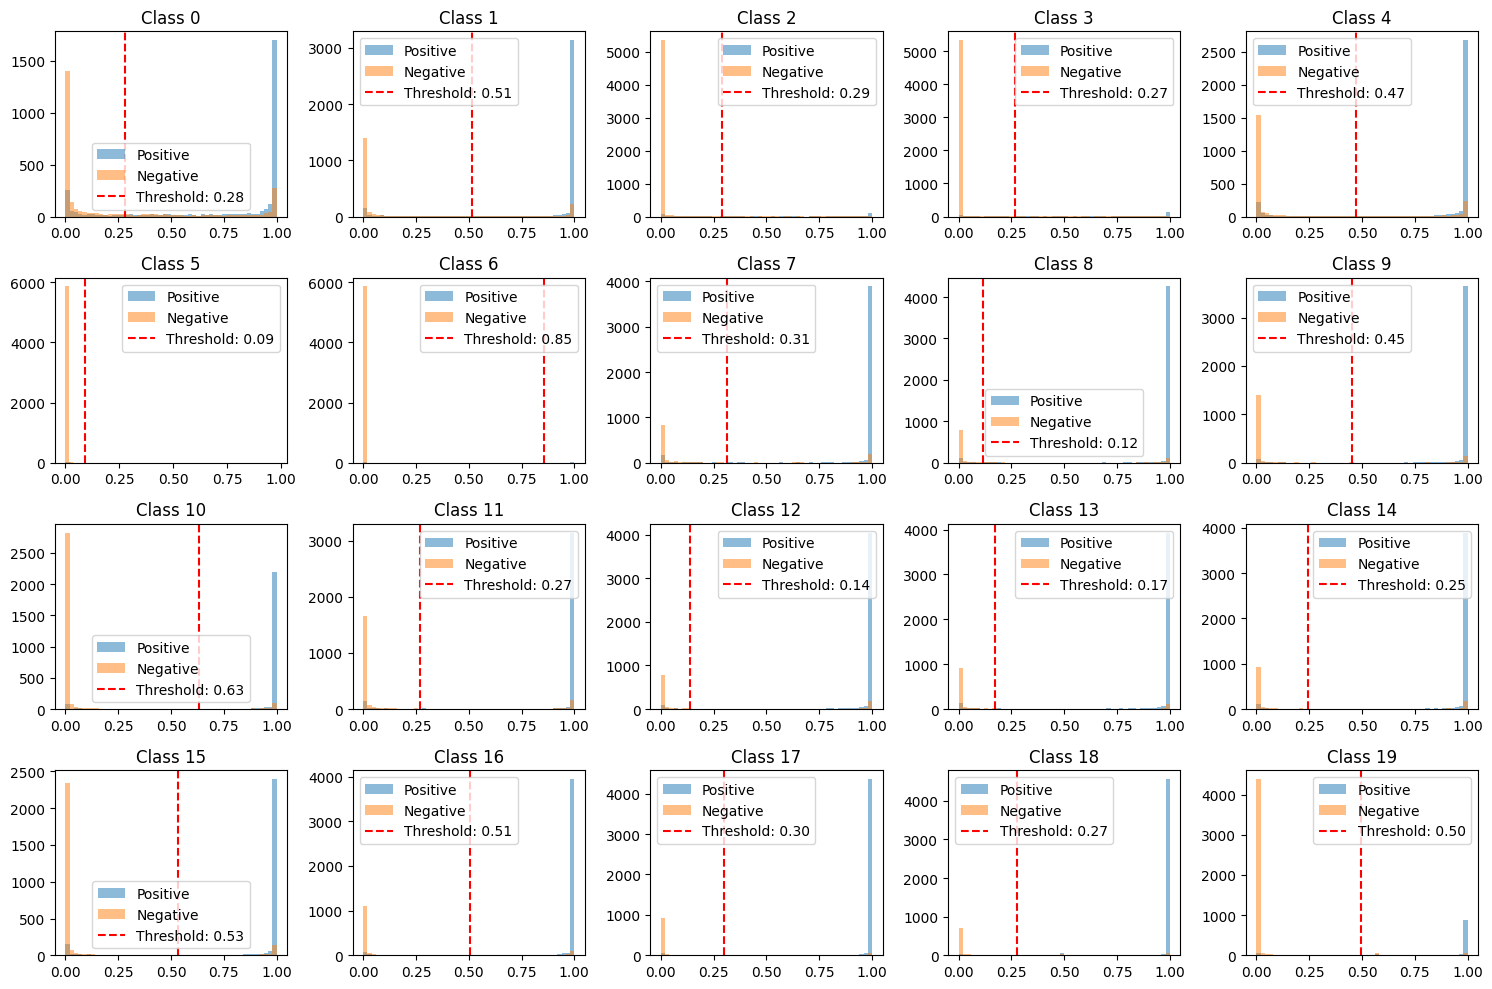

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.hist(val_preds[val_labels[:, i] == 1, i], bins=50, alpha=0.5, label='Positive')
    plt.hist(val_preds[val_labels[:, i] == 0, i], bins=50, alpha=0.5, label='Negative')
    plt.axvline(optimal_thresholds[i], color='red', linestyle='--', label=f'Threshold: {optimal_thresholds[i]:.2f}')
    plt.title(f'Class {i}')
    plt.legend()
plt.tight_layout()
plt.show()

In [13]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score

# Загрузка лучшей модели
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TfidfMLP(input_dim, output_dim).to(device)
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# Применение пайплайнов очистки текста на тесте
test['tfidf_ready'] = test['text_clean'].apply(tfidf_preprocess)

# Преобразование тестового набора в тензоры
test_tensor = torch.tensor(vectorizer.transform(test['tfidf_ready']).toarray(), dtype=torch.float32).to(device)

# Получаем предсказания вероятностей (с сигмоидой, так как используем BCEWithLogitsLoss)
with torch.no_grad():
    predictions = torch.sigmoid(model(test_tensor)).cpu().numpy()

# Применяем оптимальные пороги для каждого класса
predicted_labels = np.zeros_like(predictions)
for i in range(predictions.shape[1]):
    predicted_labels[:, i] = (predictions[:, i] > optimal_thresholds[i]).astype(int)

# Преобразуем предсказания в строковый формат
submission = pd.DataFrame({
    'id': test.index,
    'labels': [' '.join(map(str, row)) for row in predicted_labels.astype(int)]
})

# Сохраняем результат
submission.to_csv('submission_optimal_thresholds.csv', index=False)
print("Submission file with optimal thresholds created!")

Submission file with optimal thresholds created!
